In [1]:
import pandas as pd
import numpy  as np
from os import listdir
from os.path import isfile, join
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import data_tools
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import least_squares
from scipy import stats
import statsmodels.api as sm
from my_time_series import (
    fit_AR_LS,
    residuals_AR,
    tests_gaussian_white_noise, 
)

In [2]:
class dam_data:
    def __init__(self, cap_max = 0, cap_min = 0, dam_height = 0, area_skm = 0, river = 0, near_city = 0, dam_name = None, main_use = None):
        self.cap_max    = cap_max
        self.cap_min    = cap_min
        self.dam_height = dam_height
        self.area_skm   = area_skm
        self.river      = river
        self.near_city  = near_city
        self.name       = dam_name
        self.main_use   = main_use
        
    def __str__(self):
           return f'id is: {self.id}\n name is: {self.name}\n main use is: {self.main_use}\n maximum capacity is: {self.cap_max}\n minimum capacity is: {self.cap_min}\n height of the dam is: {self.dam_height}\n area is: {self.area_skm}\n river is: {self.river}\n nearest city is: {self.near_city}'

## Preprocessing

In [30]:
dam_id = 1112

path = data_tools.from_id_to_time_series(dam_id)

dam_ts = pd.read_csv(path)
data_tools.add_year_month_database(dam_ts)

dam_ts = dam_ts.groupby('yearmonth').mean()

dam_ts.index = dam_ts.index.astype(int)

In [31]:
ele_ts = pd.read_csv('APUS37A72610.csv')

## Convert string to numeric and interpolate missings (2 missings in electricity prices)

for idx in range(len(ele_ts.APUS37A72610)):
    
    elem = ele_ts.APUS37A72610[idx]
    if elem == '.':
        a = ele_ts.APUS37A72610[idx-1]
        b = eval(ele_ts.APUS37A72610[idx+1])
        
        ele_ts.APUS37A72610[idx] = (a+b)/2
        
    else:
        ele_ts.APUS37A72610[idx] = eval(elem)
        
## Convert DATE to yearmonth

for idx in ele_ts.index:
        date = ele_ts.loc[idx,'DATE']
        date = date.split('-')

        if np.isnan(ele_ts.APUS37A72610[idx]):
            continue

        ele_ts.loc[idx,'yearmonth'] = eval(date[0] + date[1])
        
ele_ts = ele_ts.drop('DATE',axis=1)
ele_ts = ele_ts.set_index('yearmonth')
ele_ts.index = ele_ts.index.astype(int)

In [27]:
ele_ts = pd.read_csv('prices_arkansas.csv')
ele_ts = ele_ts.transpose()
ele_ts.columns = ele_ts.iloc[0]
ele_ts = ele_ts[1:]

In [28]:
ele_ts

description,Tennessee : all sectors,Arkansas : all sectors
Jan 2001,5.59,5.69
Feb 2001,5.51,5.6
Mar 2001,5.48,5.73
Apr 2001,5.51,6.04
May 2001,5.55,6.16
...,...,...
May 2022,10.34,9.74
Jun 2022,11.1,10.43
Jul 2022,12.0,10.82
Aug 2022,12.82,10.75


In [29]:
ts

NameError: name 'ts' is not defined

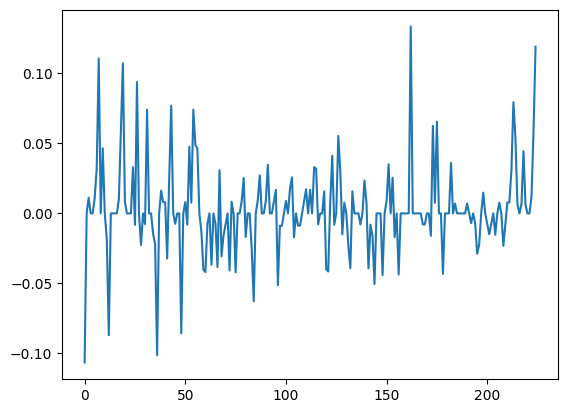

In [6]:
plt.plot(np.log((ele_ts.values[300:]/ele_ts.values[299:-1])[:,0].astype(float)))
plt.show()

In [7]:
## set same time intervales for both series

new_index = dam_ts.index.intersection(ele_ts.index)

dam_ts = dam_ts.loc[new_index,:]
ele_ts = ele_ts.loc[new_index,:]

ts = ele_ts.merge(dam_ts, left_index=True, right_index=True)
ts = ts.rename(columns= {'APUS37A72610': 'price'})

In [8]:
yearmonth = list(ts.index)
x_label   = data_tools.from_index_to_dates(yearmonth)

In [9]:
ts = ts.iloc[302:,:]
x_label = x_label[302:]

In [107]:
ts.to_csv('Preprocessed_data/ts.csv')

## Fitting LR to evaporation and filtration

### Filtration 

In [22]:
filtration = ts.inflow[1:]+ ts.storage[:-1] - (ts.evaporation[1:] + ts.storage[1:] + ts.outflow[1:])

In [23]:
np.sum(filtration<0)

95

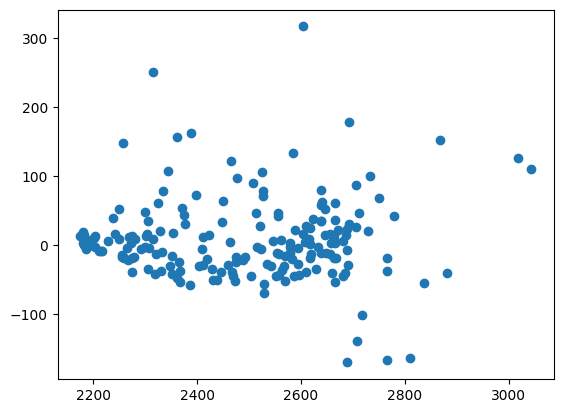

In [24]:
plt.scatter(ts.storage,filtration)
plt.show()

### Evaporation

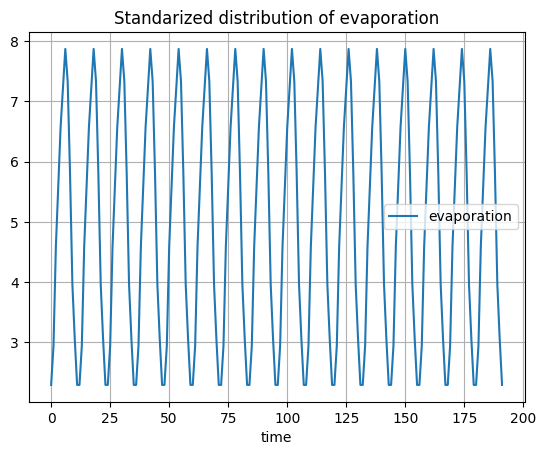

In [25]:
plt.plot(range(len(ts.index)),(ts.evaporation),label='evaporation')
#plt.plot(range(len(ts.index)),(ts.storage- np.mean(ts.storage))/np.std(ts.storage),label='storage')
plt.title('Standarized distribution of evaporation')
plt.grid()
plt.xlabel('time')
plt.legend()
plt.show()

In [26]:
ts.corr()

,storage,inflow,outflow,elevation,evaporation
storage,1.000000,0.583605,0.758789,0.999464,0.221903
inflow,0.583605,1.000000,0.513761,0.572767,-0.138077
outflow,0.758789,0.513761,1.000000,0.749686,0.158430
elevation,0.999464,0.572767,0.749686,1.000000,0.227988
evaporation,0.221903,-0.138077,0.158430,0.227988,1.000000


In [27]:
evaporation_model = LinearRegression()
evaporation_model.fit(ts.storage.values[:-1].reshape(-1,1),ts.evaporation.values[1:].reshape(-1,1))

print(evaporation_model.coef_)
print(evaporation_model.intercept_)

[[0.00512425]]
[-7.77258008]


In [30]:
reg = QuantileRegressor().fit(ts.storage.values[:-1].reshape(-1,1),ts.evaporation.values[1:].reshape(-1,1))

print(reg.coef_)
print(reg.intercept_)

/home/ignacio/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.00741527]
-13.237247438629177


In [24]:
line_q = lambda x: reg.intercept_ + reg.coef_[0] * x

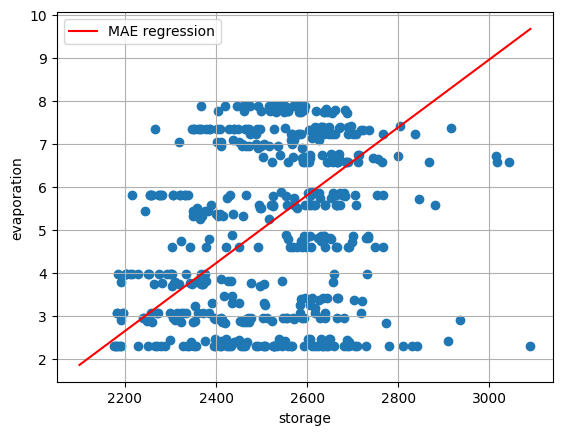

In [25]:
plt.scatter(ts.storage,ts.evaporation)
x = np.arange(2100,3100, 10)
plt.plot(x, line_q(x), 'r', label = 'MAE regression')
plt.xlabel('storage')
plt.ylabel('evaporation')
plt.grid()
plt.legend()
plt.show()

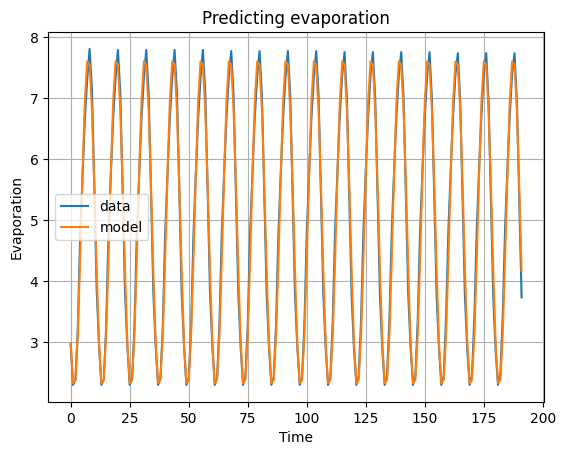

In [203]:
M = 192
plt.plot(times[:M], evaporation[:M], label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
plt.legend()
plt.grid()
plt.title('Predicting evaporation')
plt.ylabel('Evaporation')
plt.xlabel('Time')
plt.show()

In [36]:
np.savetxt('Models/coeficients/evaporation.csv', final_coefs, delimiter=',')

In [4]:
%%file Models/models.py

from numpy import loadtxt, sin, pi

coefs = loadtxt('Models/coeficients/evaporation.csv')

def model_evaporation(t):
    return coefs[0] + coefs[1] * sin((coefs[2]+t)*2*pi/12)


Writing Models/models.py


## Inflow model

### Model inflow

In [175]:
%%latex

The equation to minimize is:
    
\begin{equation*}
    \Phi_t = \rho \Phi_{t-1} + \gamma \left[ sin\left( (t+\tau)\frac{2\pi}{12} \right) - \rho sin\left( (t-1+\tau)\frac{2\pi}{12} \right) \right] + \mu + \sigma \xi_t \;\;\;\; \xi_t \sim N(0,1)
\end{equation*}

<IPython.core.display.Latex object>

In [176]:
%%latex

If the model does not have autocorrelations then we shall fit is:

\begin{equation*}
        \Phi_t = \beta_0 + \gamma sin\left( (t+\tau)\frac{2\pi}{12} \right) + \sigma \xi_t \;\;\;\; \xi_t \sim N(0,1)
\end{equation*}

<IPython.core.display.Latex object>

In [177]:
## Define the model.

def model(coefs,t):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

inflows = ts.inflow.values
times      = np.arange(0,len(ts.index),1)

def residuals(coefs):
    return model(coefs, times) - inflows

coefs0 = [1,2,3]
res1   = least_squares(residuals, coefs0)

In [178]:
final_coefs = res1.x

prediction = model(final_coefs, times)

<ipython-input-179-c307fe4354d2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


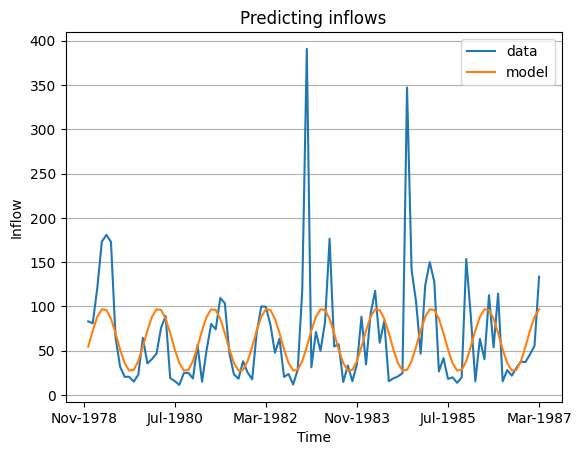

In [179]:
M = 100
plt.plot(times[1:M+1], inflows[1:M+1], label= 'data')
plt.plot(times[1:M+1], prediction[:M], label='model')
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    l.append(x_label[int(e)])
ax.set_xticklabels(l)
plt.legend()
plt.grid(axis='y')
plt.title('Predicting inflows')
plt.ylabel('Inflow')
plt.xlabel('Time')
plt.show()

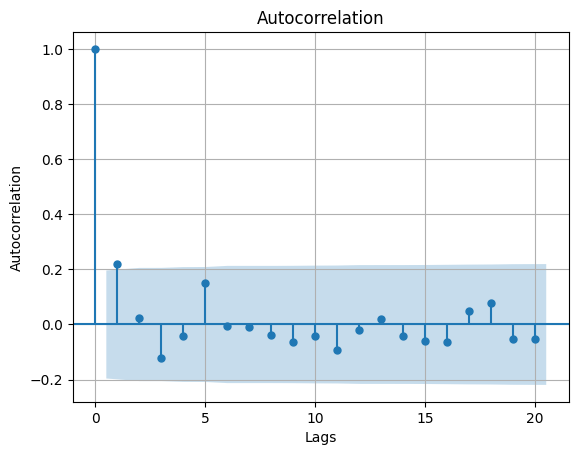

In [180]:
plot_acf(inflows[:M]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [181]:
## Define the model.

def model(coefs,t):
    return coefs[0] + coefs[1] * (t% 12 == 1) + coefs[2] * (t% 12 == 2) + coefs[3] * (t% 12 == 3) + coefs[4] * (t% 12 == 4) + coefs[5] * (t% 12 == 5) + coefs[6] * (t% 12 == 6) + coefs[7] * (t% 12 == 7) + coefs[8] * (t% 12 == 8) + coefs[9] * (t% 12 == 9) + coefs[10] * (t% 12 == 10)+ coefs[11] * (t% 12 == 11)

inflows = ts.inflow.values
times   = np.arange(0,len(ts.index),1)

def residuals(coefs):
    return model(coefs, times) - inflows

coefs0 = list(np.zeros(12))
res2   = least_squares(residuals, coefs0)

In [182]:
final_coefs = res2.x

prediction = model(final_coefs, times)

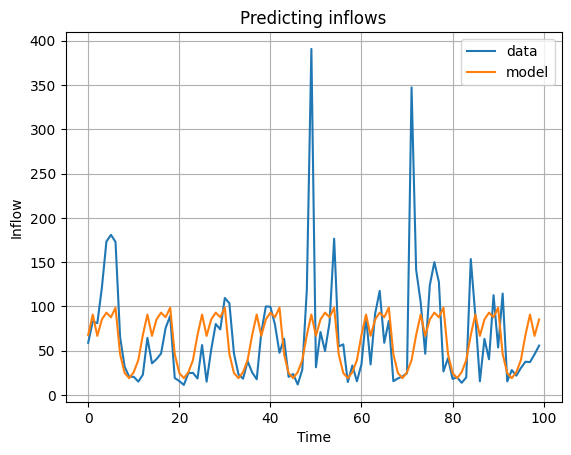

In [183]:
M = 100
plt.plot(times[:M], inflows[:M], label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
plt.legend()
plt.grid()
plt.title('Predicting inflows')
plt.xlabel('Time')
plt.ylabel('Inflow')
plt.show()

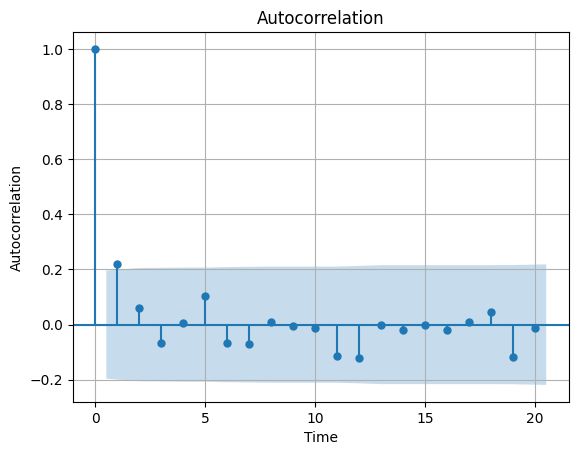

In [184]:
plot_acf(inflows[:M]-prediction[:M])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.show()

In [185]:
## Define the model.

def model(coefs,t):
    return coefs[0]*inflows[t-1]+ (1 - coefs[0]) * coefs[1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/12)- coefs[0]*np.sin((t-1+coefs[3])*2*np.pi/12))

inflows = ts.inflow.values
times   = np.arange(0,len(ts.index),1)

def residuals(coefs):
    return model(coefs, times) - inflows

coefs0 = [0,0,0,0]
res3   = least_squares(residuals, coefs0)

In [186]:
final_coefs = res3.x

prediction = model(final_coefs, times)

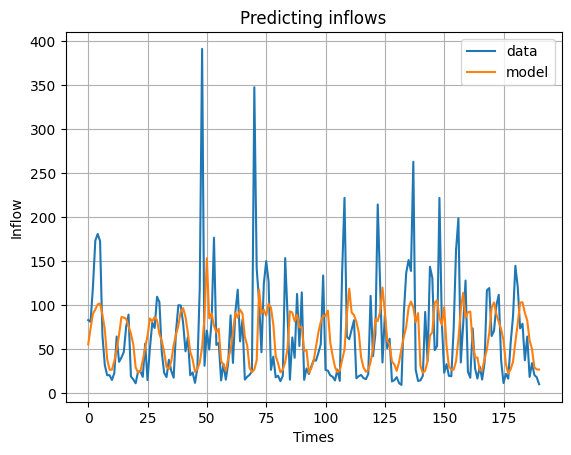

In [187]:
M = 191
plt.plot(times[:M], inflows[1:M+1], label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
plt.legend()
plt.grid()
plt.title('Predicting inflows')
plt.xlabel('Times')
plt.ylabel('Inflow')
plt.show()

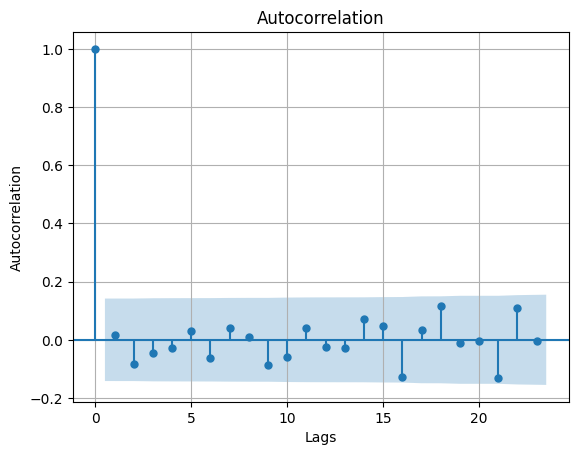

In [188]:
plot_acf(inflows[:M]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [285]:
## Define the model.

inflows = ts.inflow.values
times   = np.arange(0,len(ts.index),1)

def model(coefs,t):
    return coefs[0]*inflows[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])


def residuals(coefs):
    return model(coefs, times) - inflows

coefs0 = list(np.zeros(13))
res4   = least_squares(residuals, coefs0)

In [286]:
final_coefs = res4.x

prediction = model(final_coefs, times)

In [224]:
np.savetxt('Models/coeficients/inflow_coef.csv', final_coefs, delimiter=',')
np.savetxt('Models/coeficients/inflows.csv', inflows, delimiter=',')

In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
%%file -a Models/models.py

coefs   = loadtxt('Models/coeficients/inflow_coef.csv')
inflows = loadtxt('Models/coeficients/inflows.csv')

def model_inflow(t):
    return coefs[0]*inflows[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])

Appending to Models/models.py


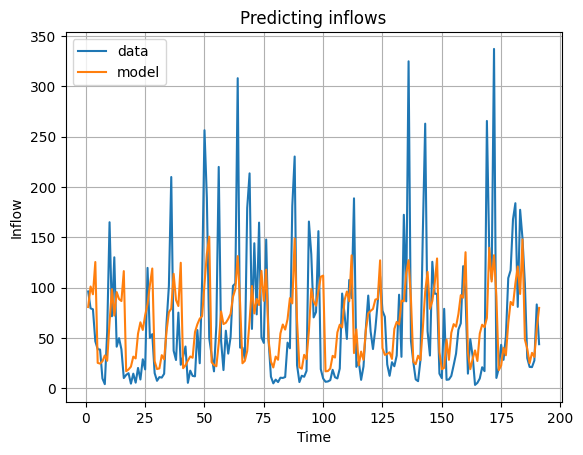

In [287]:
M = 191
plt.plot(times[1:M+1], inflows[1:M+1], label= 'data')
plt.plot(times[1:M+1], prediction[1:M+1], label='model')
ax = plt.gca()
# x = ax.get_xticks
# l = []
# for e in x()[:]:
#     l.append(x_label[int(e)])
# ax.set_xticklabels(l)
plt.legend()
plt.grid()
plt.title('Predicting inflows')
plt.xlabel('Time')
plt.ylabel('Inflow')
plt.show()

In [288]:
np.std(prediction[:]-inflows[:])

57.09283893095774

In [243]:
prediction.shape

(192,)

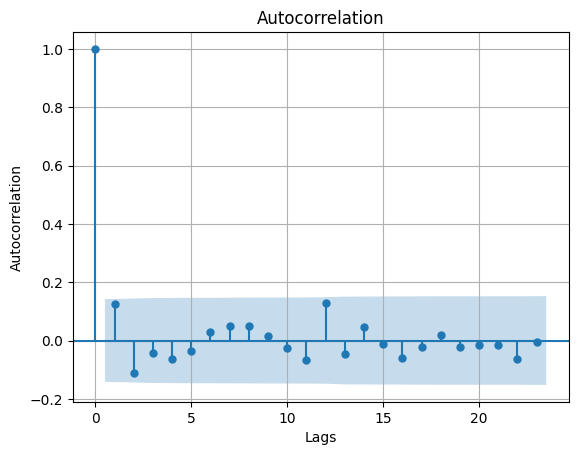

In [229]:
plot_acf(inflows[1:M+1]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [230]:
models = [res1,res2,res3,res4]

for idx in range(len(models)):
    print(f'Error model {idx} is: {models[idx].cost}')

Error model 0 is: 735581.2021976943
Error model 1 is: 690809.4083364332
Error model 2 is: 704785.8176597079
Error model 3 is: 312920.85669084324


## Storage model

In [231]:
coefficients_inflow = res4.x
coefficients_evapor = [evaporation_model.intercept_[0],evaporation_model.coef_[0][0]]
coefficients_evapor_sin = eva1.x

def model_inflow(coefs,t, ts):
    return coefs[0]*ts.inflow.values[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])

def model_evaporation(coefs,t,ts):
    return coefs[0] + coefs[1] * ts.storage.values[t-1]

def model_evaporation_sin(coefs, t, ts):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

times   = np.arange(0,len(ts.index),1)

def model_storage(model_inflow,coefs_inflow, model_evaporation, coefs_evaporation, t, ts):
    inflow      = model_inflow(coefs_inflow,t,ts)
    evaporation = model_evaporation(coefs_evaporation,t,ts)
    
    return ts.storage.values[t-1] + 2.592 * inflow - evaporation -  2.592 * ts.outflow.values[t-1]

In [232]:
times  = np.arange(1,ts.shape[0],1)

prediction = model_storage(model_inflow,coefficients_inflow, model_evaporation_sin,coefficients_evapor_sin,times,ts)

In [235]:
new_res = list(ts.storage.values[1:] - prediction)
eliminate = range(10)
for i in eliminate:
    new_res.remove(np.max(new_res))
    new_res.remove(np.min(new_res))

np.std(new_res)

76.25227376760667

<ipython-input-236-a75dcb0f243c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


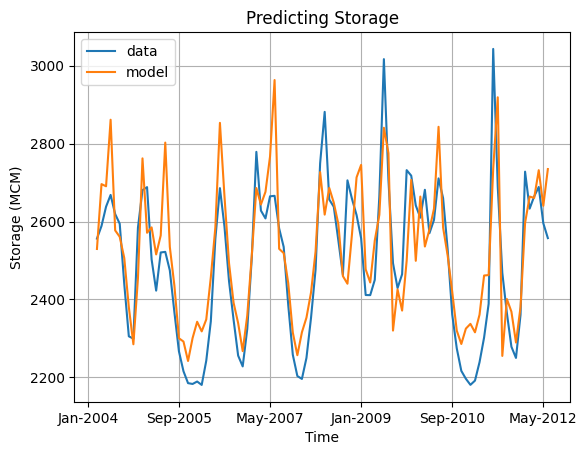

In [236]:
M = 100
plt.plot(times[1:M+1], ts.storage[1:M+1], label= 'data')
plt.plot(times[1:M+1], prediction[:M], label='model')
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    l.append(x_label[int(e)])
ax.set_xticklabels(l)
plt.legend()
plt.grid()
plt.title('Predicting Storage')
plt.xlabel('Time')
plt.ylabel('Storage (MCM)')
plt.show()

In [214]:
prediction[45:55]

array([2566.9429248 , 2513.07392046, 2514.3234035 , 2038.46499877,
       2949.63277032, 2772.01404262, 2667.53718255, 2674.28849746,
       2519.85542662, 2726.87871394])

In [65]:
score1 = np.sum( (ts.storage[1:M+1] - prediction[:M])**2)
score2 = np.sum( (ts.storage[1:M+1] - prediction_sin[:M])**2 )

print(score1)
print(score2)

NameError: name 'prediction_sin' is not defined

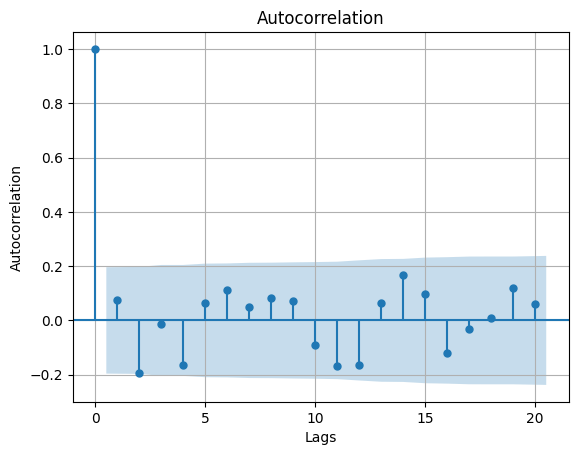

In [66]:
plot_acf(ts.storage.values[1:M+1]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [67]:
plot_acf(ts.storage.values[:M]-prediction_sin[1:M+1])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

NameError: name 'prediction_sin' is not defined

## Prices model

In [24]:
## Define the model.

def model(coefs,t):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

prices = ts.price.values
prices = np.array(prices, dtype=float)
prices = np.diff(np.log(prices))
times  = np.arange(1,len(prices),1)

def residuals(coefs):
    return model(coefs, times) - prices[1:]

coefs0 = [0,0,0]
pr1    = least_squares(residuals, coefs0)

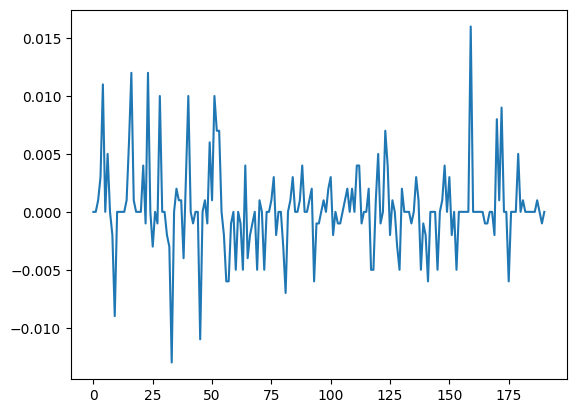

In [31]:
plt.plot(log_price[1:]- log_price[:-1])
plt.show()

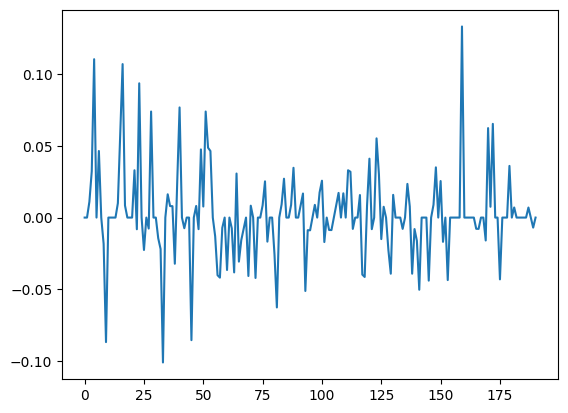

In [30]:
log_price = ts.price.values
log_price = np.array(log_price, dtype=float)
plt.plot(np.diff(np.log(log_price)))
plt.show()

<ipython-input-11-10d102d4ceff>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


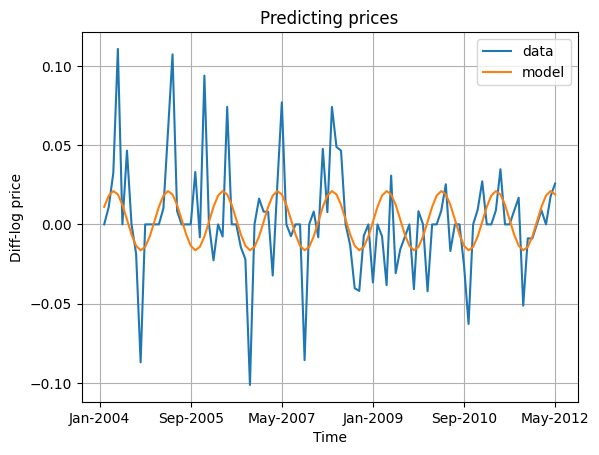

In [11]:
final_coefs = pr1.x

prediction = model(final_coefs, times)

M = 100
plt.plot(times[:M], prices[1:M+1] , label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    l.append(x_label[int(e)])
ax.set_xticklabels(l)
plt.legend()
plt.grid()
plt.title('Predicting prices')
plt.xlabel('Time')
plt.ylabel('Diff-log price')
plt.show()

In [12]:
np.std(prices[1:] - prediction[:])

0.027060425667826772

<ipython-input-13-41d27868a724>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


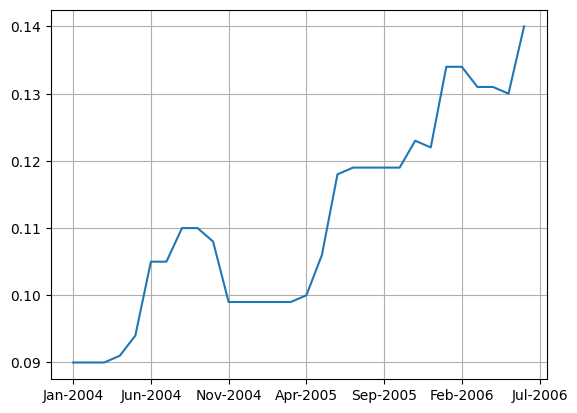

In [13]:
plt.plot(ts.price.values[:30])
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    l.append(x_label[int(e)])
ax.set_xticklabels(l)
plt.grid()
plt.show()

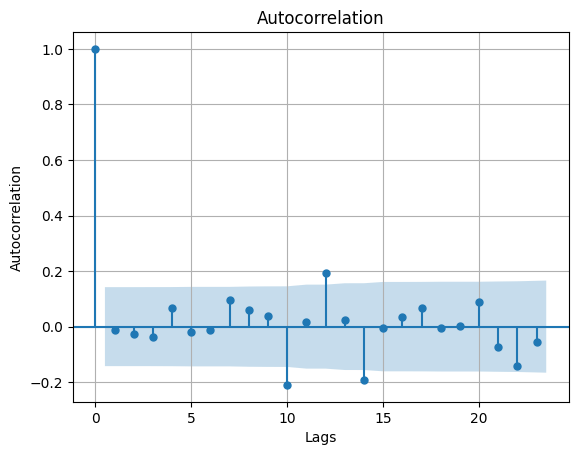

In [13]:
plot_acf(prices[1:]-prediction[:])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [14]:
## Define the model.

def model(coefs,t):
    return coefs[0] + coefs[1] * (t% 12 == 1) + coefs[2] * (t% 12 == 2) + coefs[3] * (t% 12 == 3) + coefs[4] * (t% 12 == 4) + coefs[5] * (t% 12 == 5) + coefs[6] * (t% 12 == 6) + coefs[7] * (t% 12 == 7) + coefs[8] * (t% 12 == 8) + coefs[9] * (t% 12 == 9) + coefs[10] * (t% 12 == 10)+ coefs[11] * (t% 12 == 11)

coefs0 = list(np.zeros(12))
pr2    = least_squares(residuals, coefs0)

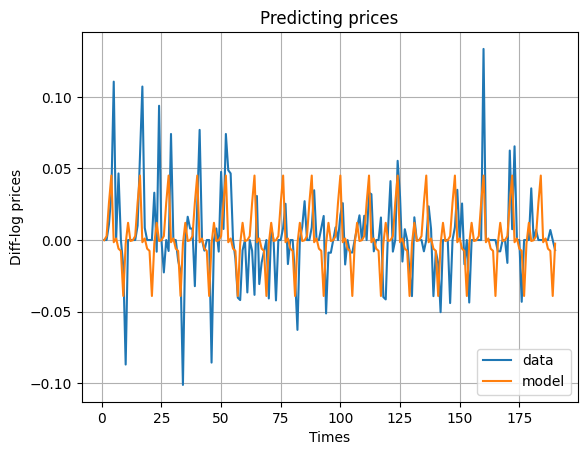

In [15]:
final_coefs = pr2.x

prediction = model(final_coefs, times)

M = 190
plt.plot(times[:M], prices[:M], label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
plt.legend()
plt.grid()
plt.title('Predicting prices')
plt.xlabel('Times')
plt.ylabel('Diff-log prices')
plt.show()

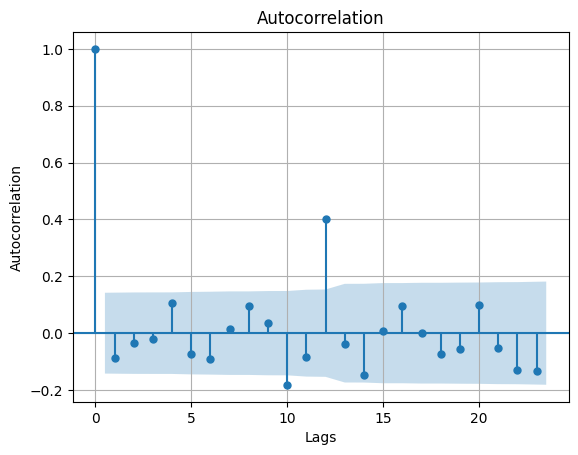

In [16]:
plot_acf(prices[:M]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [17]:
def model(coefs,t):
    return coefs[0]*prices[t-1]+ (1 - coefs[0]) * coefs[1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/12)- coefs[0]*np.sin((t-1+coefs[3])*2*np.pi/12))

coefs0 = [0,0,0,0]
pr3    = least_squares(residuals, coefs0)

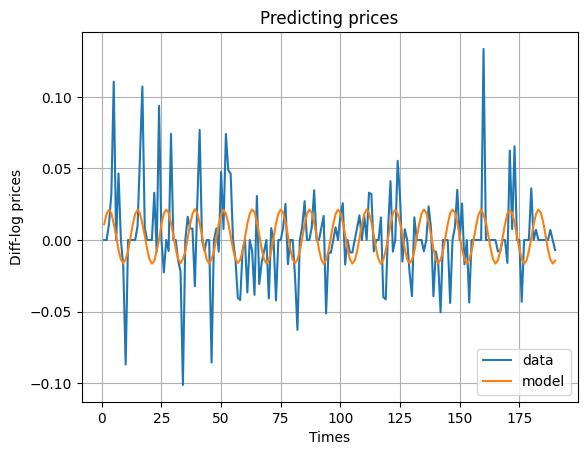

In [18]:
final_coefs = pr3.x

prediction = model(final_coefs, times)

M = 190
plt.plot(times[:M], prices[:M], label= 'data')
plt.plot(times[:M], prediction[:M], label='model')
plt.legend()
plt.grid()
plt.title('Predicting prices')
plt.xlabel('Times')
plt.ylabel('Diff-log prices')
plt.show()

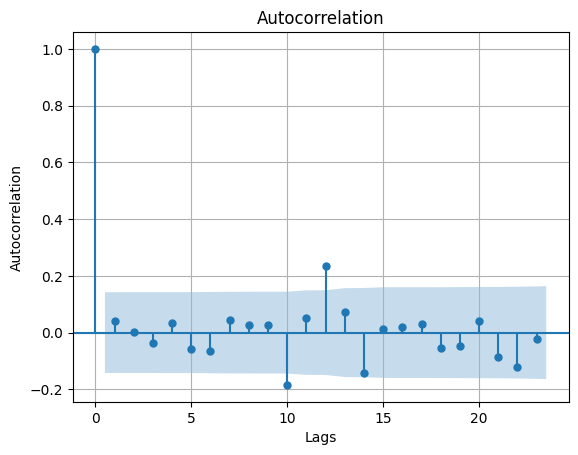

In [19]:
plot_acf(prices[:M]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [20]:
## Define the model.

def model(coefs,t):
    return coefs[0]*prices[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])

coefs0 = list(np.zeros(13))
pr4    = least_squares(residuals, coefs0)

<ipython-input-21-0ea09a5aed00>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


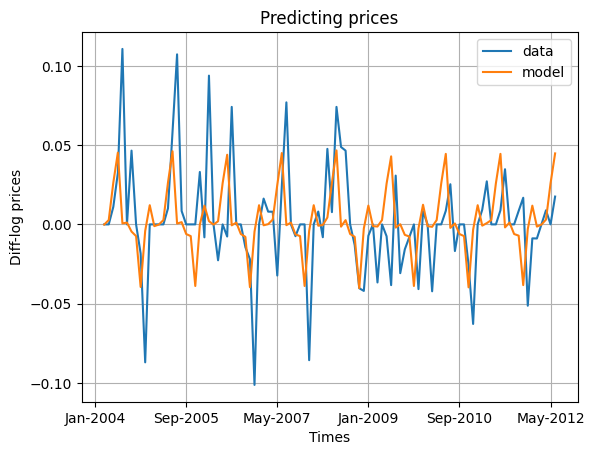

In [21]:
final_coefs = pr4.x

prediction = model(final_coefs, times)

M = 100
plt.plot(times[1:M+1], prices[:M], label= 'data')
plt.plot(times[1:M+1], prediction[:M], label='model')
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    l.append(x_label[int(e)])
ax.set_xticklabels(l)
plt.legend()
plt.grid()
plt.title('Predicting prices')
plt.xlabel('Times')
plt.ylabel('Diff-log prices')
plt.show()

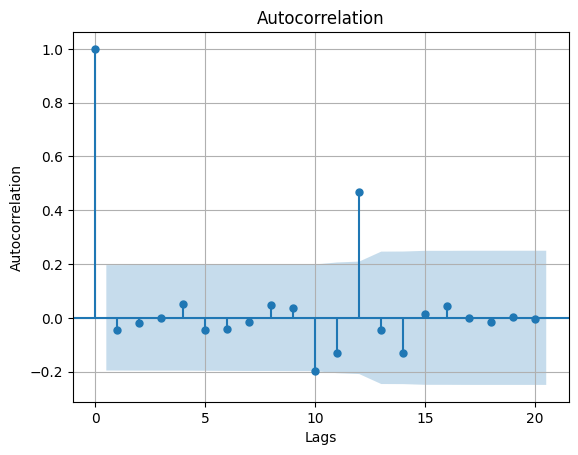

In [22]:
plot_acf(prices[:M]-prediction[:M])
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [23]:
models = [pr1,pr2,pr3, pr4]

for idx in range(len(models)):
    print(f'Error model {idx} is: {models[idx].cost}')

Error model 0 is: 0.06956533054577788
Error model 1 is: 0.050960705494025794
Error model 2 is: 0.06955621138414637
Error model 3 is: 0.05090381907263392


### mean reverting prices model

In [36]:
## Define the model.

def model(coefs,t):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

prices = ts.price.values
prices = np.array(prices, dtype=float)
prices = np.diff(np.log(prices))
times  = np.arange(1,len(prices),1)

def residuals(coefs):
    return model(coefs, times) - prices[1:]

coefs0 = np.zeros(3)
pr1    = least_squares(residuals, coefs0)

In [37]:
final_coefs = pr1.x

prediction = model(final_coefs, times)

In [38]:
np.std(prices[1:] - prediction)

0.027060425667826772

In [39]:
np.savetxt('Models/coeficients/log_prices.csv', final_coefs, delimiter=',')

In [40]:
residuals_seasonal = prices[1:]-prediction[:]

In [41]:
prices_model = LinearRegression()
prices_model.fit(residuals_seasonal[:-1].reshape(-1,1),residuals_seasonal[1:].reshape(-1,1))

LinearRegression()

In [42]:
print(prices_model.coef_)
print(prices_model.intercept_)

[[-0.01157888]]
[5.75429715e-05]


In [43]:
pred = prices_model.predict(residuals_seasonal[:-1].reshape(-1,1))
pred = pred.reshape(1,-1)[0]
real = residuals_seasonal[1:]

residuals = real - pred

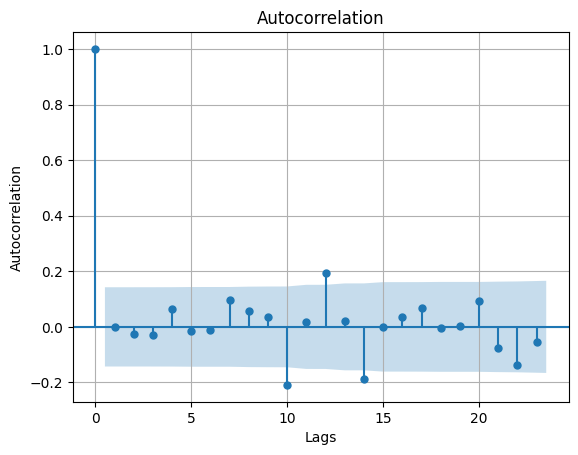

In [44]:
plot_acf(residuals)
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

### 1 y lag

In [45]:
new_predictor = np.column_stack((residuals_seasonal[:-12] ,residuals_seasonal[11:-1],np.abs(residuals_seasonal[:-12]),np.abs(residuals_seasonal[11:-1])))
new_predictor = np.column_stack((residuals_seasonal[:-12] ,residuals_seasonal[11:-1]))

In [46]:
new_predictor = residuals_seasonal[11:-1].reshape(-1,1)

In [47]:
prices_model = LinearRegression()
prices_model.fit(new_predictor,residuals_seasonal[12:].reshape(-1,1))

LinearRegression()

In [48]:
X_with_intercept.T @ X_with_intercept

NameError: name 'X_with_intercept' is not defined

In [32]:
N = new_predictor.shape[0]
p = new_predictor.shape[1] + 1  # plus one because LinearRegression adds an intercept term

X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = new_predictor

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ residuals_seasonal[12:].reshape(-1,1)
print(beta_hat)

y_hat = prices_model.predict(new_predictor)
residuals = residuals_seasonal[12:].reshape(-1,1) - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

NameError: name 'new_predictor' is not defined

In [90]:
np.savetxt('Models/coeficients/mean_rever.csv', np.reshape(beta_hat,3)[1:], delimiter=',')

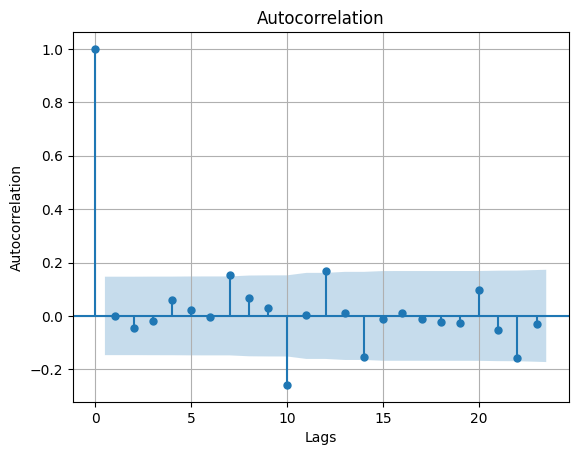

In [99]:
plot_acf(residuals)
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [105]:
new_res = list(residuals.reshape(1,-1)[0])
eliminate = range(0)
for i in eliminate:
    new_res.remove(np.max(new_res))
    new_res.remove(np.min(new_res))

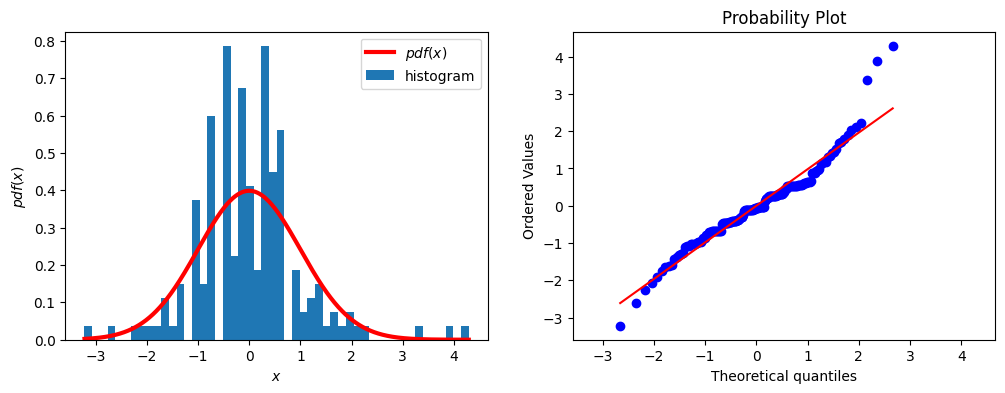

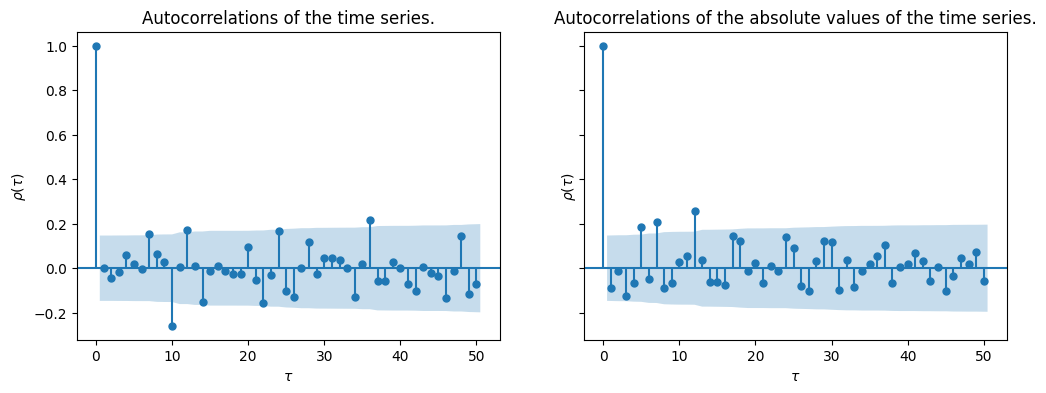

In [106]:
mu_moments = np.mean(new_res)
sigma_moments = np.std(new_res)

tests_gaussian_white_noise((new_res - mu_moments)/sigma_moments, figsize=(12, 4),lags = 50)
plt.show()

In [132]:
print(np.sum(np.array(new_res)**2))
print(np.sum(residuals**2))

1.6364681336473168
2.373704545957734


### 1 y lag and 11 dummies

In [211]:
def model(coefs,t):
    return coefs[0]*prices[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])

def residuals(coefs):
    return model(coefs, times) - prices[1:]

coefs0 = list(np.zeros(13))
pr4    = least_squares(residuals, coefs0)

In [212]:
final_coefs = pr4.x

prediction = model(final_coefs, times)
residuals_seasonal = prices[1:]-prediction[:]

In [213]:
new_predictor = np.column_stack((residuals_seasonal[:-12] ,residuals_seasonal[11:-1],np.abs(residuals_seasonal[:-12]),np.abs(residuals_seasonal[11:-1])))

In [214]:
prices_model = LinearRegression()
prices_model.fit(new_predictor,residuals_seasonal[12:].reshape(-1,1))

LinearRegression()

In [215]:
N = new_predictor.shape[0]
p = new_predictor.shape[1] + 1  # plus one because LinearRegression adds an intercept term

X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = new_predictor

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ residuals_seasonal[12:].reshape(-1,1)
print(beta_hat)

y_hat = prices_model.predict(new_predictor)
residuals = residuals_seasonal[12:].reshape(-1,1) - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

[[-0.01343361]
 [ 0.22472105]
 [-0.03825735]
 [-0.05704797]
 [ 0.37031539]]
SE(beta_hat[0]): 0.0042514720458440205
SE(beta_hat[1]): 0.042674760430502924
SE(beta_hat[2]): 0.04264287888629682
SE(beta_hat[3]): 0.05227509734726502
SE(beta_hat[4]): 0.052140058042622194


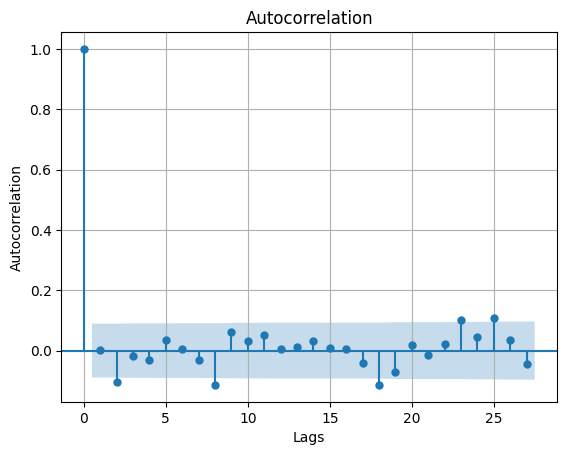

In [216]:
plot_acf(residuals)
plt.grid()
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [218]:
new_res = list(residuals.reshape(1,-1)[0])
new_res.remove(np.max(new_res))
new_res.remove(np.min(new_res))

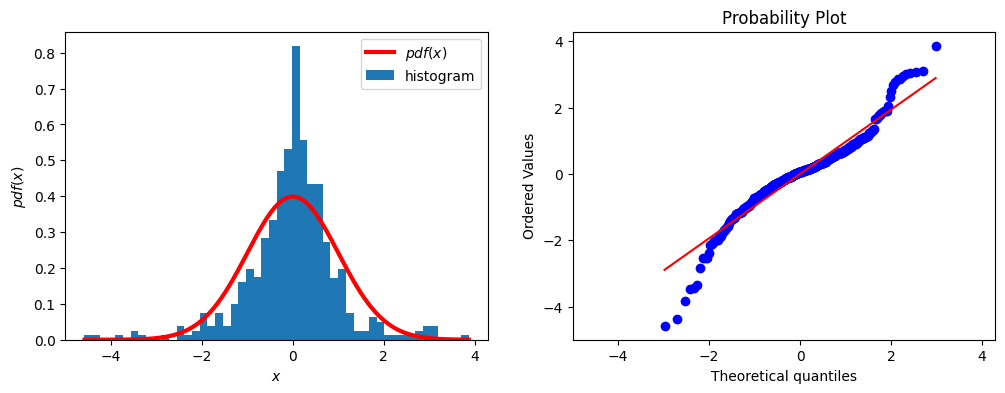

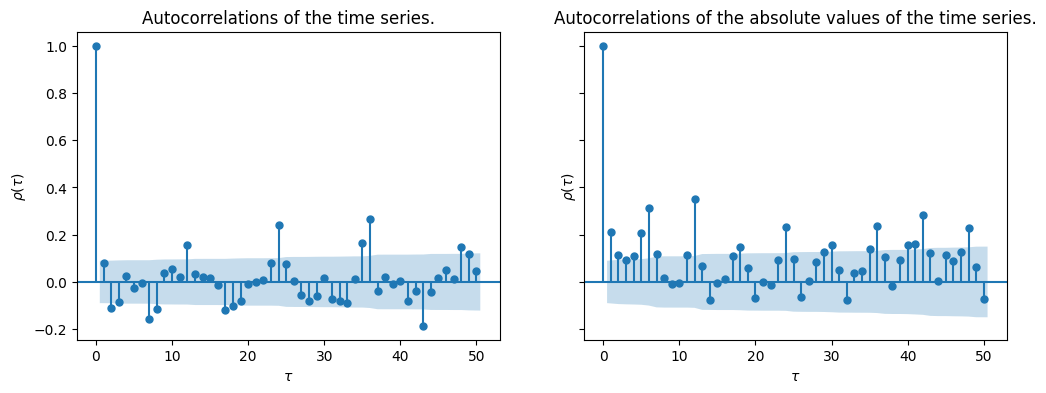

In [219]:
mu_moments = np.mean(new_res)
sigma_moments = np.std(new_res)

tests_gaussian_white_noise((new_res - mu_moments)/sigma_moments, figsize=(12, 4),lags = 50)
plt.show()

In [220]:
print(np.sum(np.array(new_res)**2))
print(np.sum(residuals**2))

1.4987581862692434
2.158532482488866


In [222]:
jarque_bera_test = stats.jarque_bera(new_res)
jarque_bera_test

Jarque_beraResult(statistic=252.19722540384706, pvalue=0.0)

# Turbine and profits

## Defining z(I)

In [160]:
elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

In [161]:
## Checking that elevention has the same order as storage

i = 0
for idx in range(len(elev_stor)-1):
    if elev_stor[idx][0] > elev_stor[idx+1][0]:
        i += 1

if i == 0:
    print('correctly ordered')
else:
    print(f'there are {i} elements that are not properly ordered')

there are 53 elements that are not properly ordered


In [505]:
def z(I,elev_stor):
    unzipped = list(zip(*elev_stor))
    
    if I <= np.min(unzipped[1]):
        return elev_stor[0][0]
    
    if I >= np.max(unzipped[1]):
        return elev_stor[-1][0]
    
    for idx in range(1,len(elev_stor)):
        prev_storage = elev_stor[idx-1][1]
        curr_storage = elev_stor[idx][1]
        
        if prev_storage == curr_storage:
            continue
        
        if I >= prev_storage and I < curr_storage:
            prev_height = elev_stor[idx-1][0]
            curr_height = elev_stor[idx][0]
            
            return prev_height + (curr_height-prev_height) * (I - prev_storage)/(curr_storage-prev_storage)

## Profit at time t funcion (pi(t))

In [162]:
# Random parameters
eta   = 1
q_min = 1
q_max = 2
I_min = 1
I_max = 2

dam_name = data_tools.dam_id_to_name(dam_id)
dam      = data_tools.dam_name_to_data(dam_name)

zd = np.max(ts.elevation) - dam.dam_height


constrains = [lambda I: I_min <= I and I_max >= I, lambda q: q_min <= q and q_max >= q]

coefficients_inflow = res4.x
coefficients_evapor_sin = eva1.x

def model_inflow(coefs,t, ts):
    return coefs[0]*ts.inflow.values[t]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6) + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9) + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11))*(1- coefs[0])

def model_evaporation_sin(coefs, t, ts):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)


def pred(ts,t,q):
    inflow      = model_inflow(coefficients_inflow,t,ts)
    evaporation = model_evaporation_sin(coefficients_evapor_sin,t,ts)
    
    return ts.storage.values[t] + inflow - evaporation - q

pi = lambda ts,t, P, q: eta * q * ((z(ts.storage.values[t],elev_stor) + z(pred(ts,t,q),elev_stor))/2 - zd) * P

NameError: name 'eva1' is not defined

In [585]:
origin = ts.iloc[-2:,:]
time   = 1
P      = ts.price.values[time]
q      = 100


def evaluation(ts, t, P, q,pi, constrains):
    objective = pi(ts, t, P, q)
    condition_I = constrains[0](pred(ts,t,q))
    condition_q = constrains[1](q)
    
    return objective, cond ition_I, condition_q

    
evaluation(origin, time, P, q, pi, constrains)

(236.32935551764038, False, False)